In [1]:
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import numpy as np
from reproject import reproject_interp
from reproject import reproject_exact
from regions import read_ds9
import copy
from photutils import SkyCircularAperture
import time
import pandas as pd

def import_coords(regionfile, ra_add = 0*u.arcsec, dec_add = 0*u.arcsec):
    regions = read_ds9(regionfile)
    coords = []
    for region in regions:
        coord = region.center
        coord = SkyCoord(ra=coord.ra+ra_add, dec=coord.dec+dec_add, frame='icrs')
        coords.append(coord)

    return coords

In [2]:
Dir = '/home/heh15/research/Antennae/'
picDir = Dir+'pictures/'
regionDir = Dir+'regions/'
HST_Dir = Dir+'HST/'
MUSE_Dir = Dir+'MUSE/'
imageDir = Dir+'images/'

# data
cont_Band3_GMC = Dir + '2018/cont_100GHz/image/'\
                       'ngc4038_band3_cont_12m_7m.fits'
cont_Band3_SC = Dir + '2016/Band3/ngc40389overlap_band3_uvrange_robust_2_smooth.fits'
cont_Band3_SC_p5 = Dir + '2016/Band3/ngc40389overlap_band3_uvrange_robust_p5_smooth_pbcor.fits'
cont_Band3_SC_p5_009 = Dir + '2016/Band3/ngc40389overlap_band3_uvrange_robust_p5_smooth_090_pbcor.fits'
cont_Band6_GMC = Dir + '2018/cont_200GHz/image/'\
                       'ngc4038_band6_cont_12m_7m.fits'
cont_Band7_SC = Dir + '2016/Band7/ngc40389overlap_band7_range_robust_2_smooth.fits'
cont_Band7_SC_p5 = Dir + '2016/Band3/ngc40389overlap_band7_range_robust_p5_smooth_pbcor.fits'

#### Measure the distance between the peaks

In [3]:
indexes = ['1a','2','5','6','7','9']
# Paschen beta coordinates
regionfile_Pb = regionDir + 'source_HST_Pbeta_imfit_contsub.reg'
coords_Pb = import_coords(regionfile_Pb)

# radio coordinates
regionfile_radio = regionDir + 'source_coords_band7_2016.reg'
coords_radio = import_coords(regionfile_radio)
# remove source 1b
SC1b_coord = coords_radio.pop(1)

ra_errs = [0.0077, 0.0059, 0.0082, 0.013, 0.0052, 0.0087]
dec_errs = [0.0079,0.0074, 0.0069, 0.011, 0.0054, 0.0086]

# calculate the offset
ras_diff = []; decs_diff = []
for i, coord in enumerate(coords_radio):
    offset_frame = coords_Pb[i].transform_to(coord.skyoffset_frame())
    ras_diff.append(offset_frame.lon.arcsec)
    decs_diff.append(offset_frame.lat.arcsec)
#    print(round(offset_frame.lon.arcsec,3), round(offset_frame.lat.arcsec,3))
offsets_SC = pd.DataFrame({'RA offset':ras_diff, 'RA err':ra_errs,'Dec offset':decs_diff,'Dec err':dec_errs},index=indexes)
print(offsets_SC)

    RA offset  RA err  Dec offset  Dec err
1a   0.061312  0.0077      0.1260   0.0079
2   -0.095374  0.0059     -0.0504   0.0074
5    0.027250  0.0082     -0.1008   0.0069
6   -0.078345  0.0130     -0.0576   0.0110
7   -0.040876  0.0052     -0.1296   0.0054
9    0.068128  0.0087     -0.0792   0.0086


Check the offset but smooth the radio continuum to have the same resolution as the optical data

In [5]:
indexes = ['1a','2','5','6','7','9']
# Paschen beta coordinates
regionfile_Pb = regionDir + 'source_HST_Pbeta_imfit_contsub.reg'
coords_Pb = import_coords(regionfile_Pb)

# radio coordinates
regionfile_radio = regionDir + 'source_coords_all_p201.reg'
coords_radio = import_coords(regionfile_radio)
# remove source 1b
SC1b_coord = coords_radio.pop(1)

dec_errs = [0.0077, 0.0059, 0.0082, 0.013, 0.0052, 0.0087]
ra_errs = [0.0079,0.0074, 0.0069, 0.011, 0.0054, 0.0086]

# calculate the offset
ras_diff = []; decs_diff = []
for i, coord in enumerate(coords_radio):
    offset_frame = coords_Pb[i].transform_to(coord.skyoffset_frame())
    ras_diff.append(offset_frame.lon.arcsec)
    decs_diff.append(offset_frame.lat.arcsec)
#    print(round(offset_frame.lon.arcsec,3), round(offset_frame.lat.arcsec,3))
offsets_SC_smooth = pd.DataFrame({'RA offset':ras_diff, 'RA err':ra_errs,'Dec offset':decs_diff,'Dec err':dec_errs},index=indexes)
print(offsets_SC_smooth)

    RA offset  RA err  Dec offset  Dec err
1a   0.057906  0.0079      0.1188   0.0077
2   -0.091968  0.0074     -0.0504   0.0059
5    0.027250  0.0069     -0.1008   0.0082
6   -0.085158  0.0110     -0.0648   0.0130
7   -0.047689  0.0054     -0.1332   0.0052
9    0.091973  0.0086     -0.0828   0.0087


Compare with coordinates of the GMC resolution image

In [6]:
# set the index
indexes = ['1','2','3','4','5','6','7','9','10','11','12','13']

# Paschen beta coordinates
regionfile_Pb = regionDir + 'source_HST_Pbeta_imfit2.reg'
coords_Pb = import_coords(regionfile_Pb)

# radio coordinates
regionfile_radio = regionDir + 'source_coords_band3.reg'
coords_radio = import_coords(regionfile_radio)
# remove source 8
coords_radio.pop(7)

dec_errs = [0.007684410713435382, 0.005915470380388469, 0.005454221952579319, 0.009431044829391229, 0.008204879975318767, 0.007293564577866361, 0.008974695880433937, 0.007973268280766964, 0.005188271021214753, 0.0036068053911640194, 0.008769679377944135, 0.004736365134907537]
ra_errs = [0.007877694849043777, 0.007469594126363549, 0.004131016162201678, 0.009943484367174559, 0.0068458913603878305, 0.006708986721045795, 0.008855706983881276, 0.008242617261395446, 0.004975182842886641, 0.0029056677732560523, 0.007399888347744962, 0.005010617893766183]

# calculate the offset
ras_diff = []; decs_diff = []
for i, coord in enumerate(coords_radio):
    offset_frame = coords_Pb[i].transform_to(coord.skyoffset_frame())
    ras_diff.append(offset_frame.lon.arcsec)
    decs_diff.append(offset_frame.lat.arcsec)
#    print(round(offset_frame.lon.arcsec,3), round(offset_frame.lat.arcsec,3))
offsets_GMC = pd.DataFrame({'RA offset':ras_diff, 'RA err':ra_errs,'Dec offset':decs_diff,'Dec err':dec_errs},index=indexes)
print(offsets_GMC)

    RA offset    RA err  Dec offset   Dec err
1   -0.057906  0.007878      0.0216  0.007684
2   -0.030656  0.007470     -0.0792  0.005915
3    0.023843  0.004131     -0.2304  0.005454
4   -0.017031  0.009943     -0.0180  0.009431
5   -0.010219  0.006846     -0.1368  0.008205
6   -0.143065  0.006709     -0.1188  0.007294
7   -0.064720  0.008856     -0.1368  0.008975
9    0.030658  0.008243     -0.1044  0.007973
10   0.017032  0.004975     -0.0432  0.005188
11  -0.051098  0.002906     -0.1692  0.003607
12   0.057912  0.007400     -0.2556  0.008770
13   0.095385  0.005011     -0.0216  0.004736


#### Draw the vectors of the offsets

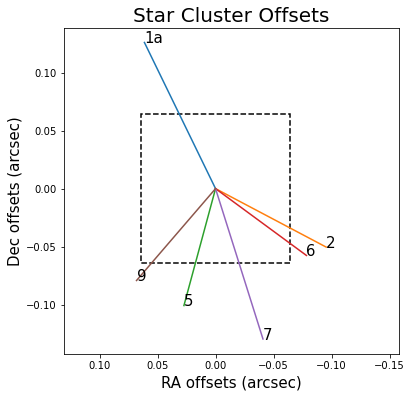

In [7]:
fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot(111)
ax1.set_title('Star Cluster Offsets',fontsize=20)
ax1.invert_xaxis()
plt.axis('equal')
for i, index in enumerate(offsets_SC.index):
    ax1.plot([0, offsets_SC['RA offset'][index]], [0,offsets_SC['Dec offset'][index]])
    ax1.text(offsets_SC['RA offset'][index], offsets_SC['Dec offset'][index], index, 
             fontsize=15)
plt.xlabel('RA offsets (arcsec)', fontsize=15)
plt.ylabel('Dec offsets (arcsec)', fontsize=15)
    
# Create a Rectangle patch
import matplotlib.patches as patches
rect = patches.Rectangle((-0.064, -0.064), 0.128, 0.128, linewidth=1.5, 
                         linestyle='--', edgecolor='black', facecolor='none')
ax1.add_patch(rect)
# fig.tight_layout()
plt.savefig(picDir+'Pbeta_radio_offset_SC.pdf',bbox_inches='tight', pad_inches=0)

The offsets for all 3 types of radio images (YMC, YMC smoothed to 0.201 arcsec and GMC resolution image)

In [ ]:
xlim = [-0.1,0.1]; ylim = [0.1,0.1]
fig = plt.figure(figsize=(15,5))

ax = plt.subplot(131)
ax.set_title('GMC offsets', fontsize=20)
ax.invert_xaxis()
plt.axis('equal')
for i, index in enumerate(offsets_GMC.index):
    ax.plot([0, offsets_GMC['RA offset'][i]], [0,offsets_GMC['Dec offset'][i]])
    ax.text(offsets_GMC['RA offset'][i], offsets_GMC['Dec offset'][i], index)

ax1 = plt.subplot(132)
ax1.set_title('SC offsets',fontsize=20)
ax1.invert_xaxis()
plt.axis('equal')
for i, index in enumerate(offsets_SC.index):
    ax1.plot([0, offsets_SC['RA offset'][index]], [0,offsets_SC['Dec offset'][index]])
    ax1.text(offsets_SC['RA offset'][index], offsets_SC['Dec offset'][index], index, 
             fontsize=15)
    
# Create a Rectangle patch
import matplotlib.patches as patches
rect = patches.Rectangle((-0.064, -0.064), 0.128, 0.128, linewidth=1.5, 
                         linestyle='--', edgecolor='black', facecolor='none')
ax1.add_patch(rect)    
    
ax2 = plt.subplot(133)
ax2.set_title('SC smoothed offsets', fontsize=20)
ax2.invert_xaxis()
plt.axis('equal')
for i, index in enumerate(offsets_SC_smooth.index):
    ax2.plot([0, offsets_SC_smooth['RA offset'][index]], [0,offsets_SC_smooth['Dec offset'][index]])
    ax2.text(offsets_SC_smooth['RA offset'][index], offsets_SC_smooth['Dec offset'][index], index,
            fontsize=15)
# Create a Rectangle patch
import matplotlib.patches as patches
rect = patches.Rectangle((-0.064, -0.064), 0.128, 0.128, linewidth=1.5, 
                         linestyle='--', edgecolor='black', facecolor='none')
ax2.add_patch(rect)

plt.savefig(picDir+'Pbeta_radio_offset_all.pdf')

## Compare the coordinates of band 3 and band 7 sources

In [ ]:
indexes = ['1a','1b','2','5','7','9']

regionfile_band3 = regionDir + 'source_band3_2016_p5_imfit_v2.reg'
coords_band3 = import_coords(regionfile_band3)

regionfile_band7 = regionDir + 'source_band7_2016_imfit_p5_band3Ap.reg'
coords_band7 = import_coords(regionfile_band7)

# for the band 3 coordinates, remove source 3 and source 4
coords_band3.pop(3)
coords_band3.pop(3)

ras_diff = []; decs_diff = []; seps = []
# calculate the offsets between band 3 and band 7
for i, coord in enumerate(coords_band3):
    sep = coords_band7[i].separation(coord)
    seps.append(sep.arcsec)
    offset_frame = coords_band7[i].transform_to(coord.skyoffset_frame())
    ras_diff.append(offset_frame.lon.arcsec)
    decs_diff.append(offset_frame.lat.arcsec)

offsets_radio = pd.DataFrame({'Seperation':seps, 'RA offset':ras_diff, 'Dec offset':decs_diff},index=indexes)
print(offsets_radio)

In [ ]:
print(offset_frame)

## Compare the optical coordinates with the radio coordinates

In [ ]:
print(coords_radio)

In [ ]:
indexes = ['1a','2','5','6','9']

regionfile = regionDir + 'source_coords_band7_2016.reg'
coords_radio = import_coords(regionfile)

regionfile_I = regionDir + 'source_HST_I_imfit.reg'
coords_I = import_coords(regionfile_I)

# remove source 1b and 7
coords_radio.pop(1)
coords_radio.pop(4)

ras_diff = []; decs_diff = []; seps = []
# calculate the offsets between band 3 and band 7
for i, coord in enumerate(coords_radio):
    sep = coords_I[i].separation(coord)
    seps.append(sep.arcsec)
    offset_frame = coords_I[i].transform_to(coord.skyoffset_frame())
    ras_diff.append(offset_frame.lon.arcsec)
    decs_diff.append(offset_frame.lat.arcsec)

offsets_I = pd.DataFrame({'Seperation':seps, 'RA offset':ras_diff, 'Dec offset':decs_diff},index=indexes)
print(offsets_I)

In [ ]:
fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot(111)
ax1.set_title('Star Cluster Offsets',fontsize=20)
ax1.invert_xaxis()
plt.axis('equal')
for i, index in enumerate(offsets_I.index):
    ax1.plot([0, offsets_I['RA offset'][index]], [0,offsets_I['Dec offset'][index]])
    ax1.text(offsets_I['RA offset'][index], offsets_I['Dec offset'][index], index, 
             fontsize=15)
plt.xlabel('RA offsets (arcsec)', fontsize=15)
plt.ylabel('Dec offsets (arcsec)', fontsize=15)
    
# Create a Rectangle patch
import matplotlib.patches as patches
rect = patches.Rectangle((-0.064, -0.064), 0.128, 0.128, linewidth=1.5, 
                         linestyle='--', edgecolor='black', facecolor='none')
ax1.add_patch(rect)
# fig.tight_layout()
plt.savefig(picDir+'I_radio_offset_SC.pdf',bbox_inches='tight', pad_inches=0)